In [53]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import pprint
import metis
import networkit as nk
import networkx as nx
from networkit import vizbridges
import pickle
import powerlaw
from itertools import combinations

In [54]:
# 파일 불러오기
with open('../../data/df.pkl', 'rb') as f:
    df = pickle.load(f)


In [55]:
# 파일 불러오기
with open('../../data/df_qna.pkl', 'rb') as f:
    df_qna = pickle.load(f)

In [56]:
df_gephi = df[['q_owneruserid', 'a_owneruserid']]

In [57]:
df_gephi.columns = ['Source', 'Target']

In [58]:
node = np.unique(np.append(df_gephi['Source'].values, df_gephi['Target'].values))

In [59]:
# 질문자->답변자 로 edgelist 생성
edgelist = list(zip(df_gephi['Source'], df_gephi['Target']))

In [60]:
di_github = nx.DiGraph()
di_github.add_nodes_from(node)
di_github.add_edges_from(edgelist)

github = nx.from_pandas_edgelist(df,  source='q_owneruserid', target='a_owneruserid')

In [61]:
df_gephi.to_csv('../../data/gephi.csv', index=False)

In [62]:
di_github_nk = nk.nxadapter.nx2nk(di_github)
github_nk = nk.nxadapter.nx2nk(github)

In [63]:
print(di_github_nk.numberOfNodes(), di_github_nk.numberOfEdges())

11392 11996


scale free network -> 불평등한 분포 (hub가 존재한다)

Barabasi-Albert model 
* Barabasi-Albert model indicates that two simple machanisms, growth and preferential attatchment, are responsible for the emergence of scale-free networks.
* The emergence of hubs are result of a rich-get-richer phenomemon


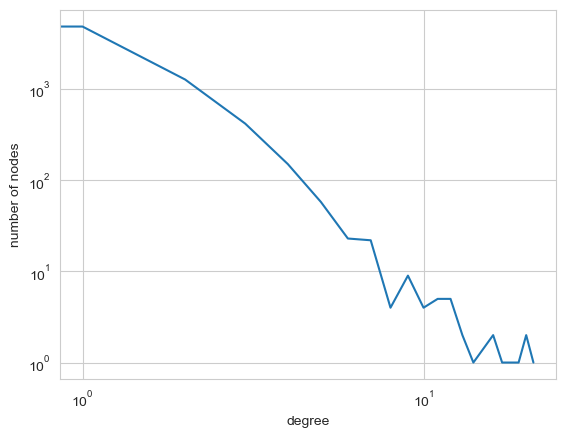

In [64]:
dd = sorted(nk.centrality.DegreeCentrality(di_github_nk).run().scores(), reverse=True)
degrees, numberOfNodes = np.unique(dd, return_counts=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(degrees, numberOfNodes)
plt.show()

In [65]:
try:
    fit = powerlaw.Fit(dd)
except ImportError:
    print ("Module powerlaw could not be loaded")

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


### Centrality
who is the core?

In [66]:
degree = nx.degree_centrality(di_github)
indegree = nx.in_degree_centrality(di_github)
outdegree = nx.out_degree_centrality(di_github)
betweenness = nx.betweenness_centrality(di_github)
closeness = nx.closeness_centrality(di_github)
# eigenvector = nx.eigenvector_centrality(di_github)
# PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# 에러 발생하는 이유 찾아야..
# https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality?rq=1
# eigenvector = nx.eigenvector_centrality_numpy(di_github, tol=1.0e-3)
eigenvector = nx.eigenvector_centrality_numpy(di_github)

nx.set_node_attributes(di_github, degree, 'degree')
nx.set_node_attributes(di_github, betweenness, 'betweenness')
nx.set_node_attributes(di_github, closeness, 'closeness')
nx.set_node_attributes(di_github, eigenvector, 'eigenvector')
nx.set_node_attributes(di_github, indegree, 'indegree')
nx.set_node_attributes(di_github, outdegree, 'outdegree')

In [67]:
df_centrality = pd.DataFrame.from_dict(dict(di_github.nodes(data=True)), orient='index')

In [68]:
df_centrality

,degree,betweenness,closeness,eigenvector,indegree,outdegree
214,0.000088,0.0,0.000000,1.962146e-19,0.000000,0.000088
1238,0.000088,0.0,0.000000,1.542790e-18,0.000000,0.000088
1968,0.000088,0.0,0.000088,-7.463423e-19,0.000088,0.000000
2648,0.000439,0.0,0.000000,1.018005e-12,0.000088,0.000351
2732,0.000088,0.0,0.000000,1.431207e-18,0.000000,0.000088
...,...,...,...,...,...,...
23027979,0.000088,0.0,0.000000,1.509527e-18,0.000000,0.000088
23028285,0.000176,0.0,0.000000,7.372307e-19,0.000000,0.000176
23028978,0.000088,0.0,0.000000,1.935897e-18,0.000000,0.000088
23029300,0.000088,0.0,0.000000,8.797523e-19,0.000000,0.000088


In [69]:
sorted_degree = df_centrality.sort_values(by='eigenvector', ascending=False)
sorted_degree.head()

,degree,betweenness,closeness,eigenvector,indegree,outdegree
17758716,0.030814,3.029054e-06,0.030649,0.634012,0.030638,0.000176
992484,0.002721,0.000000e+00,0.018058,0.634011,0.002721,0.000000
619830,0.008954,0.000000e+00,0.009145,0.411203,0.008867,0.000088
6314354,0.000088,0.000000e+00,0.002158,0.000003,0.000088,0.000000
4222206,0.004126,3.930833e-07,0.003937,0.000003,0.003950,0.000176


In [70]:
all_com = list(combinations(list(sorted_degree.columns), 2))
df_list = []
for col_x, col_y in all_com :
    df_row = []
    df_row.append(col_x)
    df_row.append(col_y)
    df_row.append(np.corrcoef(sorted_degree[col_x], sorted_degree[col_y])[0][1])
    df_list.append(df_row)

df_corr = pd.DataFrame(df_list, columns =['col_x', 'col_y', 'correlation'])

In [71]:
col_list = ['indegree', 'outdegree']
row_list = ['degree', 'eigenvector', 'closeness', 'betweenness']

df_corr['col_set'] = [set(list(x)) for x in list(zip(df_corr['col_x'], df_corr['col_y']))]

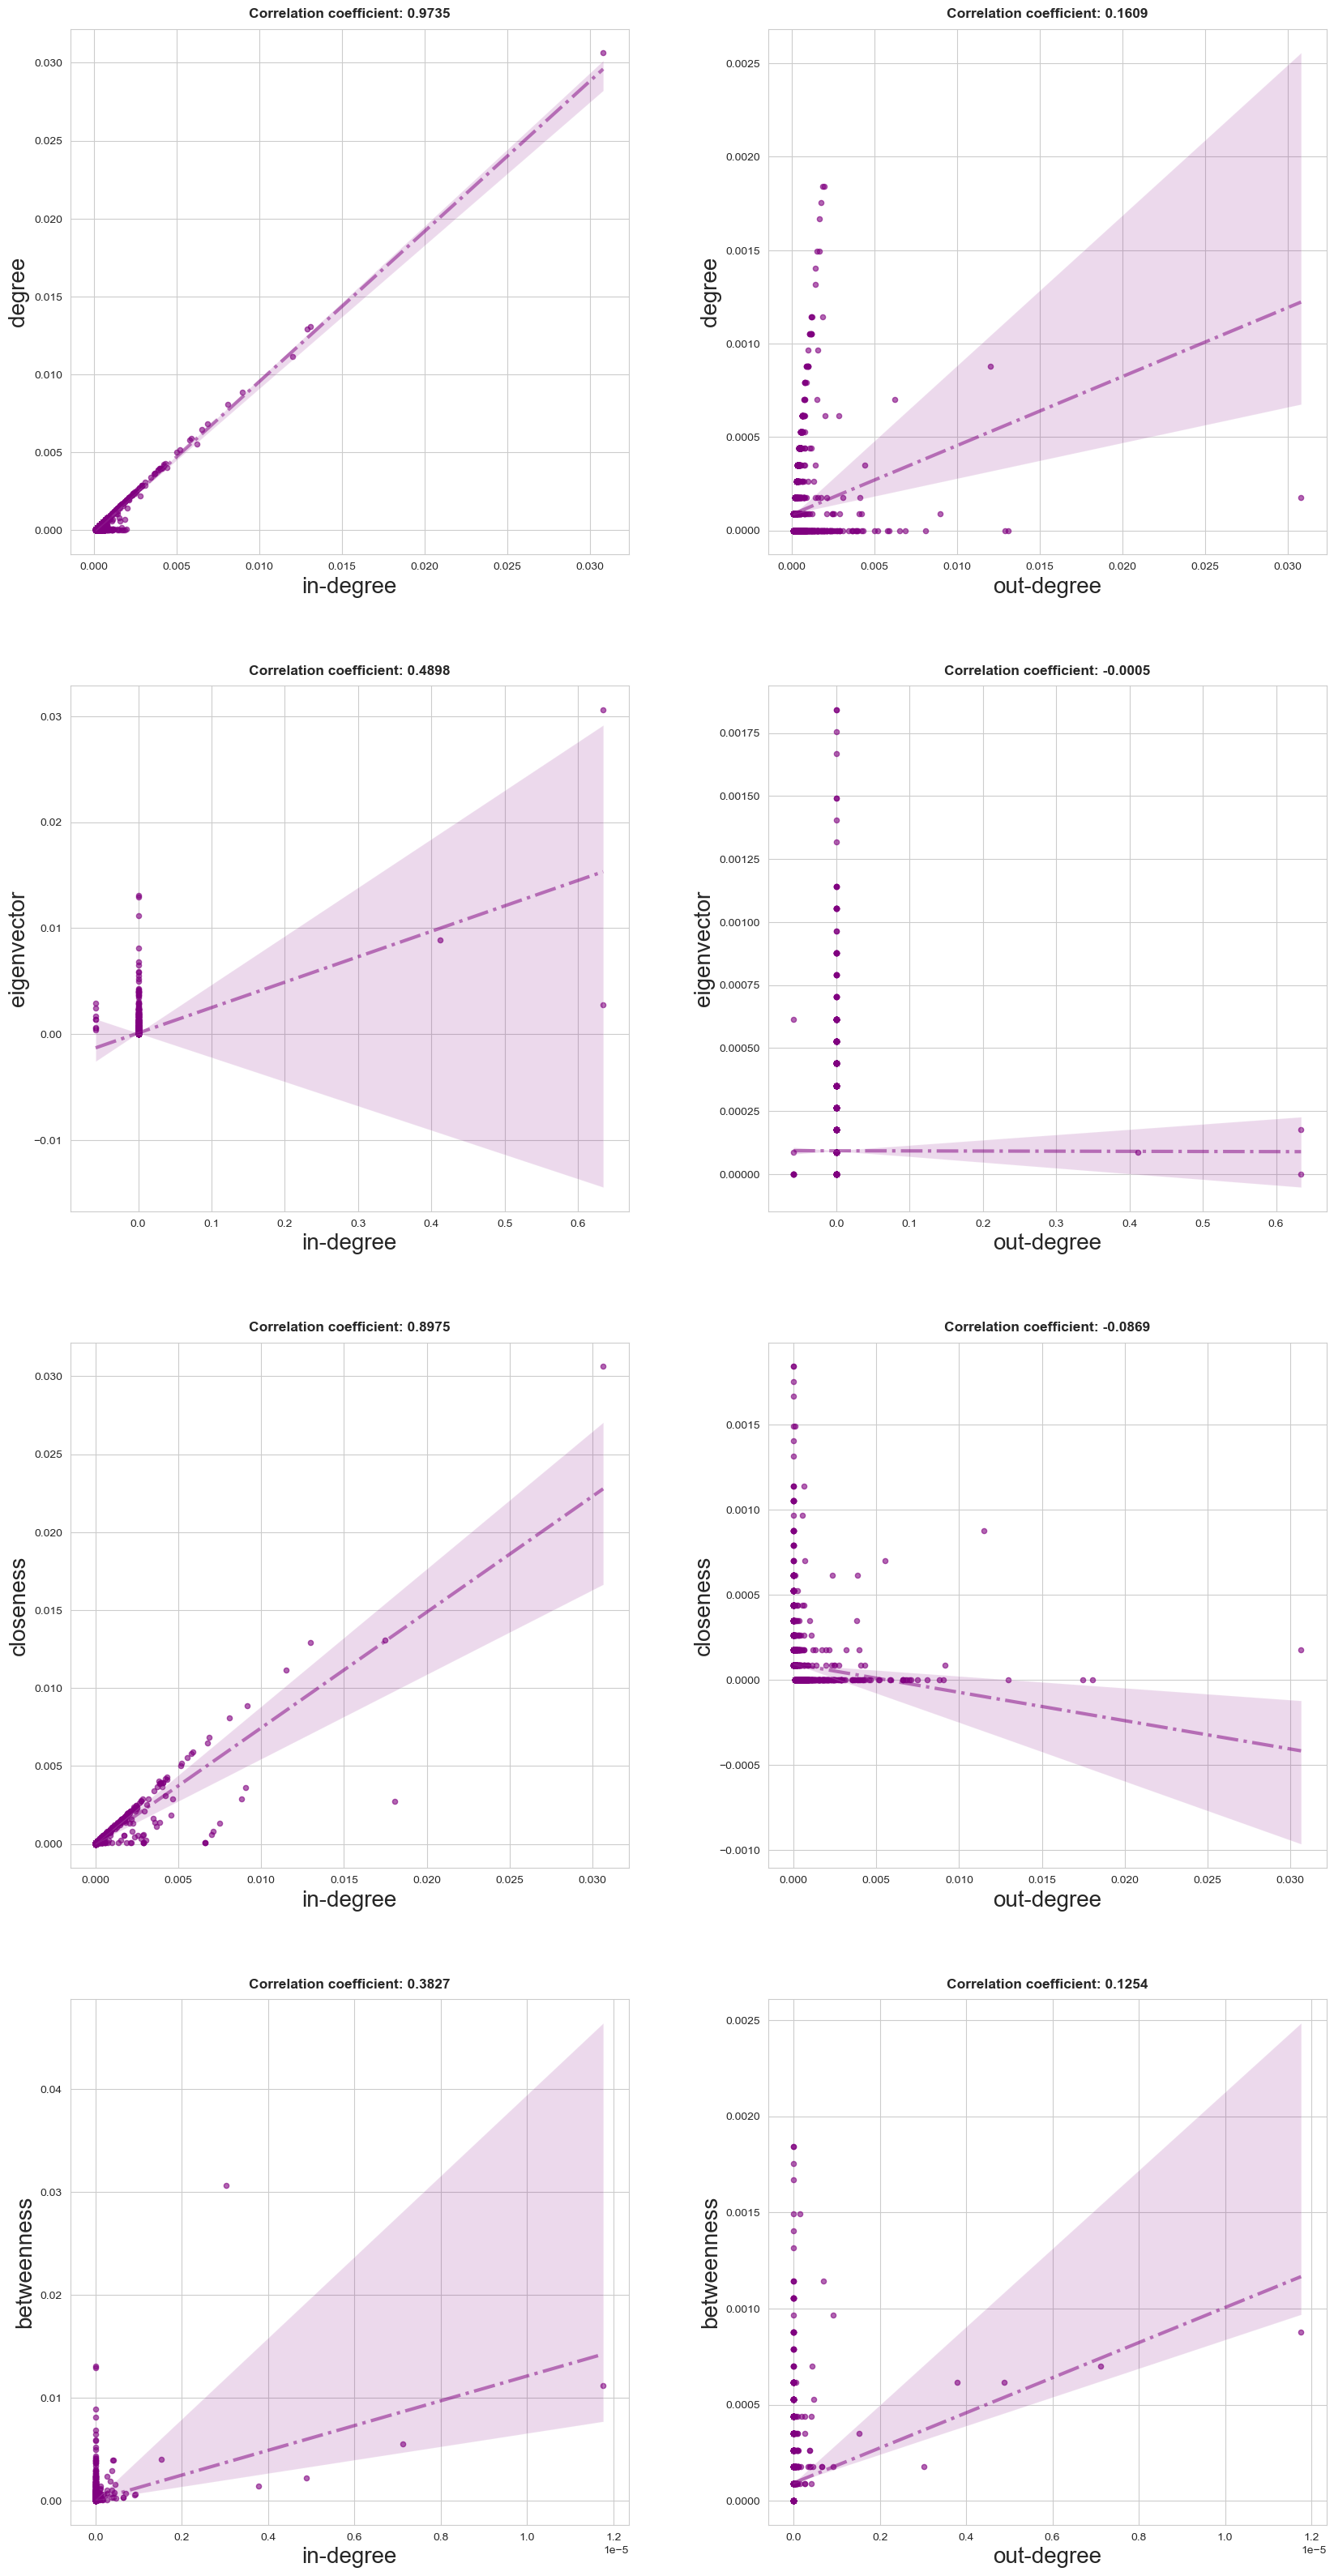

In [72]:
fig, axs = plt.subplots(4, 2, figsize = (20, 40))

for i in range(0, 4):
    for j in range(0, 2) : 
        sns.regplot(x = sorted_degree[row_list[i]] , y = sorted_degree[col_list[j]] , color = 'purple', 
                    scatter_kws = {'s': 20, 'alpha': 0.6},
                    line_kws = {'lw' : 3, 'ls' : '-.','alpha' : 0.5},
                    ax = axs[i][j])

        cc = df_corr.loc[df_corr['col_set']== set([row_list[i],col_list[j]]), 'correlation'].values[0]

        axs[i][j].set_title('Correlation coefficient: ' + str(np.round(cc, 4)), # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
        axs[i][j].set_ylabel(row_list[i], fontsize = 20.0) # add title
        axs[i][j].set_xlabel(col_list[j].replace('degree', '')+'-degree', fontsize = 20.0) # add title
        

fig.subplots_adjust(wspace = 0.25, hspace = 0.25)
plt.show();

#### 그래프 해석
* degree centrality  
    - in-degree 와 out-degree 중 in-degree와의 상관관계가 매우 높고, out-degree의 경우 0에 가까움 
    - degree가 높다는것은 그래프 내에서 여러 노드와 관계를 맺고 있다는 것으로, stackoverflow네트워크에서는 답변 하는 구루가 그러한 위치에 존재함 
* eigenvector centrality  
    - 그래프 내에서 노드의 중심성은 그 주변 노드의 중심성으로 계산한다는 centrality 
    - in-degree 와 out-degree 모두 상관관계가 매우 낮음 
    - SNS에서의 인플루언서와는 다른 양상을 보임(유명인들의 친구는 유명인) 
    - 지식을 나누는 곳이기 때문에 구루끼리 연결되어있기 보다는 그 제자들과 연결되어있어서 eigenvector centrality가 낮다고 볼 수 있음 
* closeness centrality 
    - 효율적으로 뻗어나가는데 중심이 되는 노드 
    - 네트워크 내에 있는 각 노드를 기준으로 말단 노드까지의 최단거리를 기반으로 계산 
    - in-degree 와는 높은, out-degree와는 낮은 상관관계를 보이는데, 답변을 많이 하는 구루일 수록 말단 노드에 금방 다다를수 있음 
    - 그래프로 그려보면 좋을듯!
* betweenness centrality 
    -(j to k의 최단 거리 중 노드i가 포함되는 경우)/i를 통과하는 path
    - closness가 거리로 계산을 했다면, between의 경우 shortest path에 등장하는 빈도로 계산 
    - in-degree, out-degree 모두 매우 낮은 상관관계를 보임 
    - 최단거리에 포함되기 위해서는 한 노드가 in과 out모두 있어야 하는데, 이를 모두 포함하는 노드가 별로 없다는 것으로 해석 가능 
    - 또한 degree가 1인, 서로 지식을 주고받고 끝내는 노드들도 꽤 있기 때문에 수치가 좋지 않을 것으로 판단됨(ai stack overflow에서 그런 양상이 있었는데 여기에서도 그런지 확인 필요)
    - 이 또한 몇몇 구루와 제자로 샘플링 하여 그래프를 그려보면 좋을듯!

In [73]:
bc = nk.centrality.Betweenness(di_github_nk)
bc.run()
tmp_dict = dict(bc.ranking())
bc_list = []
for keys, values in tmp_dict.items():
    bc_list.append([node[keys], values])
df_b = pd.DataFrame(bc_list, columns = [ 'userid', 'betweenness']) 

In [74]:
# Eigenvector centrality
ec = nk.centrality.EigenvectorCentrality(di_github_nk)
ec.run()
tmp_dict = dict(ec.ranking())
ec_dict = dict()
for keys, values in tmp_dict.items():
    ec_dict[node[keys]]=values
df_e = pd.DataFrame(ec_dict, columns = ['id', 'betweenness'])

In [75]:
# PageRank
pr = nk.centrality.PageRank(di_github_nk, 1e-6)
pr.run()
tmp_dict = dict(pr.ranking())
pr_dict = dict()
for keys, values in tmp_dict.items():
    pr_dict[node[keys]]=values
df_pr = pd.DataFrame(pr_dict, columns = ['id', 'betweenness'])

In [76]:
# Closeness
c = nk.centrality.Closeness(di_github_nk, 0, True)
c.run()
tmp_dict = dict(c.ranking())
pr_c = dict()
for keys, values in tmp_dict.items():
    pr_c[node[keys]]=values
df_c = pd.DataFrame(pr_c, columns = ['id', 'betweenness'])

### Core Decomposition

In [77]:
github_nk.removeSelfLoops()

In [78]:
# coreDec = nk.centrality.CoreDecomposition(github_nk)
coreDec = nk.centrality.CoreDecomposition(github_nk)
coreDec.run()
# direct 라 안되는데
# untimeError: Core Decomposition implementation does not support graphs with self-loops. Call Graph.removeSelfLoops() first.

In [79]:
coreDec.getPartition()

In [80]:
coreDec.maxCoreNumber()

3

In [81]:
set(coreDec.scores())

{0.0, 1.0, 2.0, 3.0}

In [82]:
communities = nk.community.detectCommunities(github_nk, inspect=True)

Communities detected in 0.01743 [s]
solution properties:
-------------------  -----------
# communities        2492
min community size      1
max community size    741
avg. community size     4.57143
imbalance             148.2
edge cut             1088
edge cut (portion)      0.105314
modularity              0.870728
-------------------  -----------


In [83]:
nk.community.Modularity().getQuality(communities, github_nk)

0.8707283495713057

In [84]:
print("{0} elements assigned to {1} subsets".format(communities.numberOfElements(),
communities.numberOfSubsets()))

11392 elements assigned to 2492 subsets


In [85]:
print("the biggest subset has size {0}".format(max(communities.subsetSizes())))

the biggest subset has size 741


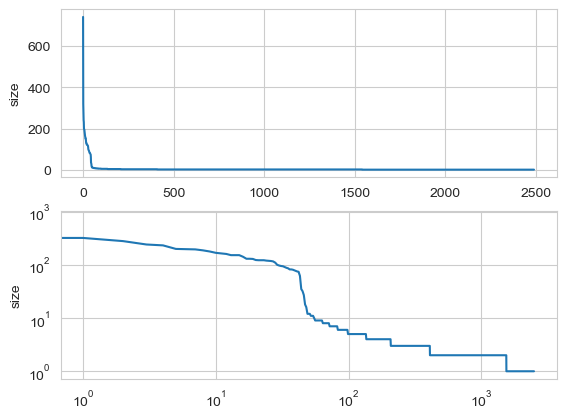

In [86]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [87]:
size_dict = {}
for key,value in enumerate(communities.subsetSizes()):
    size_dict[key] = value

In [88]:
[k for k,v in size_dict.items() if max(size_dict.values()) == v]

[4]

In [89]:
size_dict[10]

2

In [90]:
c2 = communities.getMembers(10)
g2 = nk.graphtools.subgraphFromNodes(github_nk, c2, compact=True)

In [91]:
g2.numberOfNodes()

2

In [92]:
communities2 = nk.community.detectCommunities(g2)

Communities detected in 0.00176 [s]
solution properties:
-------------------  -
# communities        1
min community size   2
max community size   2
avg. community size  2
imbalance            1
edge cut             0
edge cut (portion)   0
modularity           0
-------------------  -


In [93]:
btwn = nk.centrality.Betweenness(g2)
btwn.run()